In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
from keras.layers import Dense

In [2]:
def generate_data(low = 0.0, high = 1.0, n=100, d=3):
    np.random.seed(73)
    return np.random.uniform(low, high, (n,d))

def quadratic_func(x, sq_coef, li_coef, bias):
    """Outputs a quadratic function with n variables  
    (based on dimension of ndarray and value of coefficients passed). 
    The number of dimensions and the number of coefficients should match"""
    sq_x = np.square(x)
    return sq_x @ sq_coef.T + x @ li_coef.T + bias
    
x = generate_data(-1.0,1.0,300, 3)

y1 = quadratic_func(x, np.array([[2,3,-7]]), np.array([[-5,11,2]]), 3)
y2 = quadratic_func(x, np.array([[13,-11,7]]), np.array([[2,19,-13]]), 5)

In [3]:
def plot_4d(x1,x2,x3,y_true,y_pred=None):
    %matplotlib inline
    %matplotlib notebook

    from matplotlib import cm
    from matplotlib import colors
    from mpl_toolkits import mplot3d
    import matplotlib.pyplot as plt

    plt.rcParams["figure.figsize"] = 17, 10
    ax = plt.axes(projection='3d')
    
    max_y = np.max(y_true)
    min_y = np.min(y_true)
    
    if y_pred is not None:
        mx_pred = np.max(y_pred)
        mn_pred = np.min(y_pred)
        if mx_pred > max_y:
            max_y = mx_pred
        if mn_pred < min_y:
            min_y = mn_pred
    
    cmap = cm.get_cmap('seismic')
    norm = colors.Normalize(vmin=min_y,vmax=max_y)
    print(f'max : {max_y}  min : {min_y}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    sc1 = ax.scatter(x1, x2, x3,s=np.square(y_true[:,0] + 2),c=y_true[:,0] ,norm=norm, cmap=cmap)
    cb1 = plt.colorbar(sc1)
    cb1.set_label('y_true')
    if y_pred is not None:
        cmap2 = cm.get_cmap('PRGn')
        sc2 = ax.scatter(x1, x2, x3,s=np.square(y_pred[:,0] + 2),c=y_pred[:,0] ,norm=norm, cmap=cmap2)
        cb2 = plt.colorbar(sc2)
        cb2.set_label('y_pred')
#     sc = ax.scatter(x[:,0], x[:,1], x[:,2],s=np.square(y1[:,0] + 2),c=y1[:,0] ,norm=norm, cmap=cmap)
    plt.xlabel='x1'
    plt.ylabel='x2'
    plt.zlabel='x3'

<IPython.core.display.Javascript object>


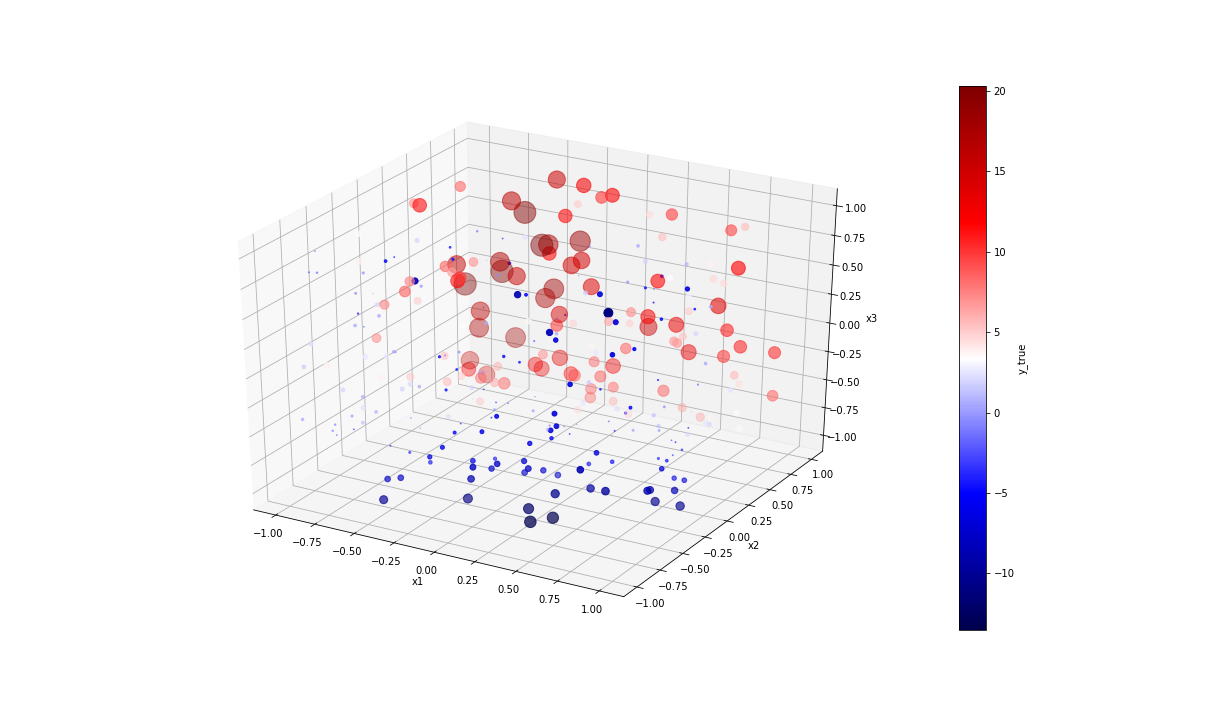

max : 20.284099794015997  min : -13.5285978007839


In [4]:
plot_4d(x[:,0], x[:,1], x[:,2], y1)

<IPython.core.display.Javascript object>


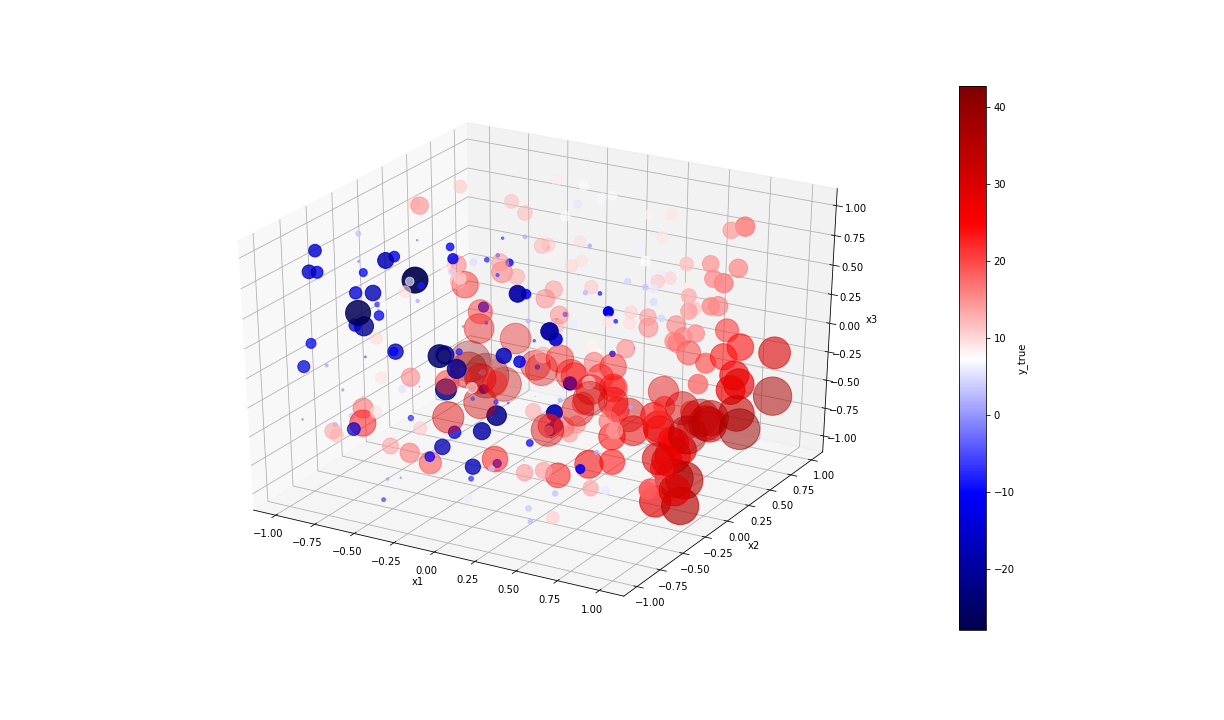

max : 42.6099130903702  min : -27.935697967500786


In [5]:
plot_4d(x[:,0], x[:,1], x[:,2], y2)

In [6]:
y_true = np.concatenate((y1,y2), axis=1)
print(x.shape)
print(y_true.shape)

(300, 3)
(300, 2)


## Using tensorflow tensors

In [9]:
x_tensor = tf.convert_to_tensor(x, np.float32)
y_true_tensor = tf.convert_to_tensor(y_true, np.float32)

In [10]:
class Linear(keras.layers.Layer):
    
    def __init__(self, num_neurons):
        super(Linear, self).__init__()
        self.num_neurons = num_neurons
        
    def build(self, input_dim):
        self.w = self.add_weight(shape=(input_dim[-1], self.num_neurons),
                               initializer='random_normal',
                               trainable=True)
        
        self.b = self.add_weight(shape=(self.num_neurons,),
                               initializer='random_normal',
                               trainable=True)
        
    def call(self, x):
        return tf.matmul(x, self.w) + self.b
    

In [30]:
class MLP(keras.layers.Layer):
    
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.linear_ip = Linear(input_dim)
        self.linear2 = Linear(5)
        self.linear_op = Linear(2)
        
    def call(self, inputs):
        x = self.linear_ip(inputs)
        x = tf.nn.relu(x)
        x = self.linear2(x)
        x = tf.nn.relu(x)
        return self.linear_op(x)

In [45]:
def fit(x, y_true, model, optimizer, num_epoch=1000):
    
    for epoch in range(num_epoch):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        with tf.GradientTape() as tape:
            y_pred = model(x)
            loss_val = tf.keras.losses.mean_squared_error(y_true, y_pred)
            mean_loss = tf.math.reduce_mean(loss_val)
            print(f'Epoch {epoch}, loss {mean_loss}')

            
        gradient = tape.gradient(loss_val , model.trainable_weights)
        optimizer.apply_gradients(zip(gradient, model.trainable_weights))

In [50]:
model = MLP(x_tensor.shape[1])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

fit(x_tensor, y_true_tensor, model, optimizer, loss)
    
# fit(x_tensor, y_true_tensor, model, loss)

Epoch 0, loss 179.2893829345703
Epoch 1, loss 177.02610778808594
Epoch 2, loss 174.8930206298828
Epoch 3, loss 172.8805694580078
Epoch 4, loss 170.97906494140625
Epoch 5, loss 169.1786346435547
Epoch 6, loss 167.46888732910156
Epoch 7, loss 165.8385772705078
Epoch 8, loss 164.27552795410156
Epoch 9, loss 162.76602172851562
Epoch 10, loss 161.29490661621094
Epoch 11, loss 159.84523010253906
Epoch 12, loss 158.3984832763672
Epoch 13, loss 156.93499755859375
Epoch 14, loss 155.43467712402344
Epoch 15, loss 153.87823486328125
Epoch 16, loss 152.247802734375
Epoch 17, loss 150.52589416503906
Epoch 18, loss 148.68682861328125
Epoch 19, loss 146.67324829101562
Epoch 20, loss 144.34100341796875
Epoch 21, loss 141.3498992919922
Epoch 22, loss 136.981689453125
Epoch 23, loss 129.92201232910156
Epoch 24, loss 118.59207153320312
Epoch 25, loss 103.67847442626953
Epoch 26, loss 90.43070983886719
Epoch 27, loss 80.6879653930664
Epoch 28, loss 73.769287109375
Epoch 29, loss 68.4902114868164
Epoch 30,

Epoch 247, loss 19.84526824951172
Epoch 248, loss 19.555095672607422
Epoch 249, loss 22.12888526916504
Epoch 250, loss 17.850730895996094
Epoch 251, loss 21.68553352355957
Epoch 252, loss 23.061893463134766
Epoch 253, loss 52.437198638916016
Epoch 254, loss 35.40299987792969
Epoch 255, loss 75.82293701171875
Epoch 256, loss 23.95229148864746
Epoch 257, loss 20.147573471069336
Epoch 258, loss 28.683944702148438
Epoch 259, loss 23.97800064086914
Epoch 260, loss 25.614147186279297
Epoch 261, loss 15.450704574584961
Epoch 262, loss 16.286409378051758
Epoch 263, loss 18.935462951660156
Epoch 264, loss 39.456886291503906
Epoch 265, loss 36.205135345458984
Epoch 266, loss 87.99642944335938
Epoch 267, loss 27.66199493408203
Epoch 268, loss 12.81032943725586
Epoch 269, loss 13.301033020019531
Epoch 270, loss 15.739508628845215
Epoch 271, loss 27.98104476928711
Epoch 272, loss 28.893016815185547
Epoch 273, loss 66.30204772949219
Epoch 274, loss 18.43232536315918
Epoch 275, loss 15.58321285247802

Epoch 487, loss 29.298316955566406
Epoch 488, loss 63.16917419433594
Epoch 489, loss 19.786989212036133
Epoch 490, loss 9.49048137664795
Epoch 491, loss 8.862954139709473
Epoch 492, loss 8.959525108337402
Epoch 493, loss 9.569146156311035
Epoch 494, loss 12.122123718261719
Epoch 495, loss 15.112622261047363
Epoch 496, loss 27.801979064941406
Epoch 497, loss 19.26228141784668
Epoch 498, loss 26.15041160583496
Epoch 499, loss 13.76717472076416
Epoch 500, loss 14.477499961853027
Epoch 501, loss 15.930468559265137
Epoch 502, loss 34.34543991088867
Epoch 503, loss 25.274715423583984
Epoch 504, loss 54.194740295410156
Epoch 505, loss 17.50822639465332
Epoch 506, loss 13.626870155334473
Epoch 507, loss 14.0881929397583
Epoch 508, loss 15.684054374694824
Epoch 509, loss 14.256011962890625
Epoch 510, loss 15.563888549804688
Epoch 511, loss 12.82237720489502
Epoch 512, loss 19.119062423706055
Epoch 513, loss 21.451160430908203
Epoch 514, loss 51.57591247558594
Epoch 515, loss 21.027149200439453


Epoch 729, loss 12.95667839050293
Epoch 730, loss 12.337909698486328
Epoch 731, loss 24.482027053833008
Epoch 732, loss 15.221297264099121
Epoch 733, loss 27.069625854492188
Epoch 734, loss 17.377344131469727
Epoch 735, loss 28.086763381958008
Epoch 736, loss 15.238343238830566
Epoch 737, loss 21.263652801513672
Epoch 738, loss 13.023423194885254
Epoch 739, loss 19.964357376098633
Epoch 740, loss 11.771684646606445
Epoch 741, loss 18.028554916381836
Epoch 742, loss 12.105632781982422
Epoch 743, loss 19.484846115112305
Epoch 744, loss 11.859431266784668
Epoch 745, loss 18.54532814025879
Epoch 746, loss 12.306371688842773
Epoch 747, loss 19.79386329650879
Epoch 748, loss 12.773548126220703
Epoch 749, loss 20.923723220825195
Epoch 750, loss 14.114635467529297
Epoch 751, loss 23.464149475097656
Epoch 752, loss 14.023777961730957
Epoch 753, loss 18.245668411254883
Epoch 754, loss 12.385257720947266
Epoch 755, loss 12.493426322937012
Epoch 756, loss 9.997871398925781
Epoch 757, loss 9.022439

Epoch 979, loss 11.322731971740723
Epoch 980, loss 16.70851707458496
Epoch 981, loss 11.575846672058105
Epoch 982, loss 16.877269744873047
Epoch 983, loss 12.095067024230957
Epoch 984, loss 17.928762435913086
Epoch 985, loss 11.901719093322754
Epoch 986, loss 16.23658561706543
Epoch 987, loss 11.29747200012207
Epoch 988, loss 14.244721412658691
Epoch 989, loss 9.89012622833252
Epoch 990, loss 11.417928695678711
Epoch 991, loss 8.734823226928711
Epoch 992, loss 9.98852825164795
Epoch 993, loss 8.514646530151367
Epoch 994, loss 10.62035846710205
Epoch 995, loss 9.80650520324707
Epoch 996, loss 14.876124382019043
Epoch 997, loss 12.807682991027832
Epoch 998, loss 21.48834228515625
Epoch 999, loss 11.742507934570312


In [51]:
y_pred_tensor = model(x_tensor)
y_pred = y_pred_tensor.numpy()
y1_pred = y_pred[:,0].reshape(300,1)
y2_pred = y_pred[:,1].reshape(300,1)

<IPython.core.display.Javascript object>


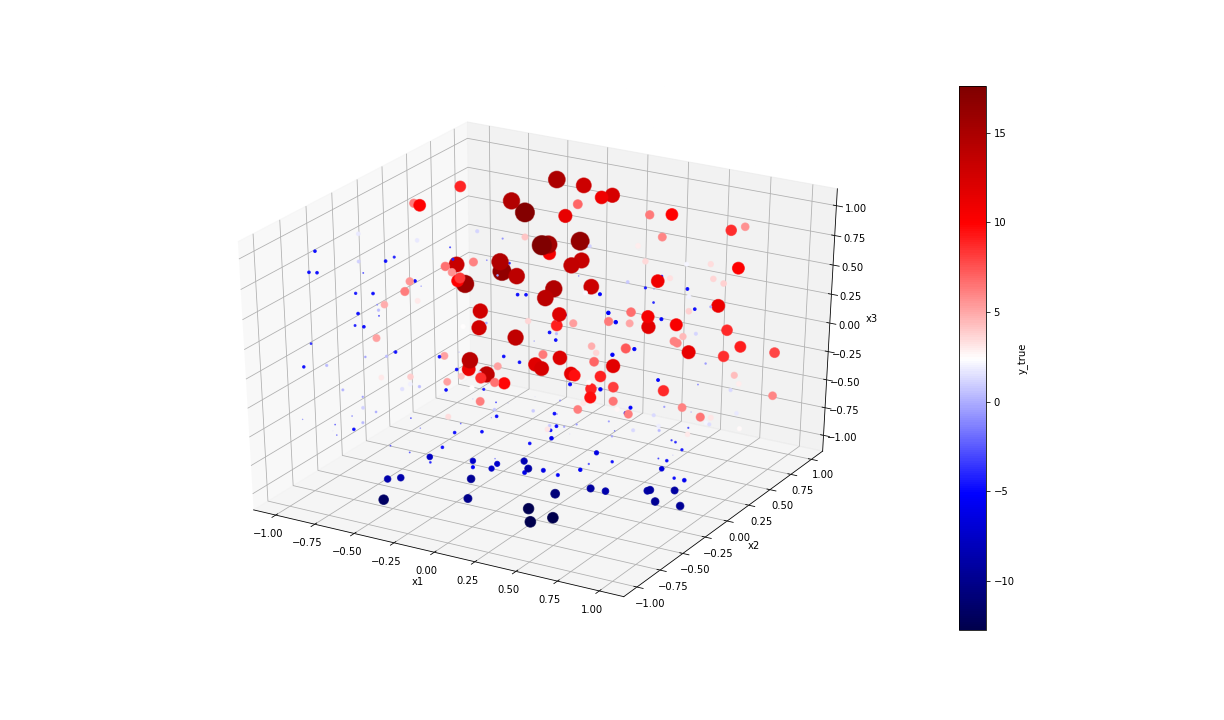

max : 17.569835662841797  min : -12.731583595275879


In [52]:
plot_4d(x[:,0], x[:,1], x[:,2], y1_pred)

<IPython.core.display.Javascript object>


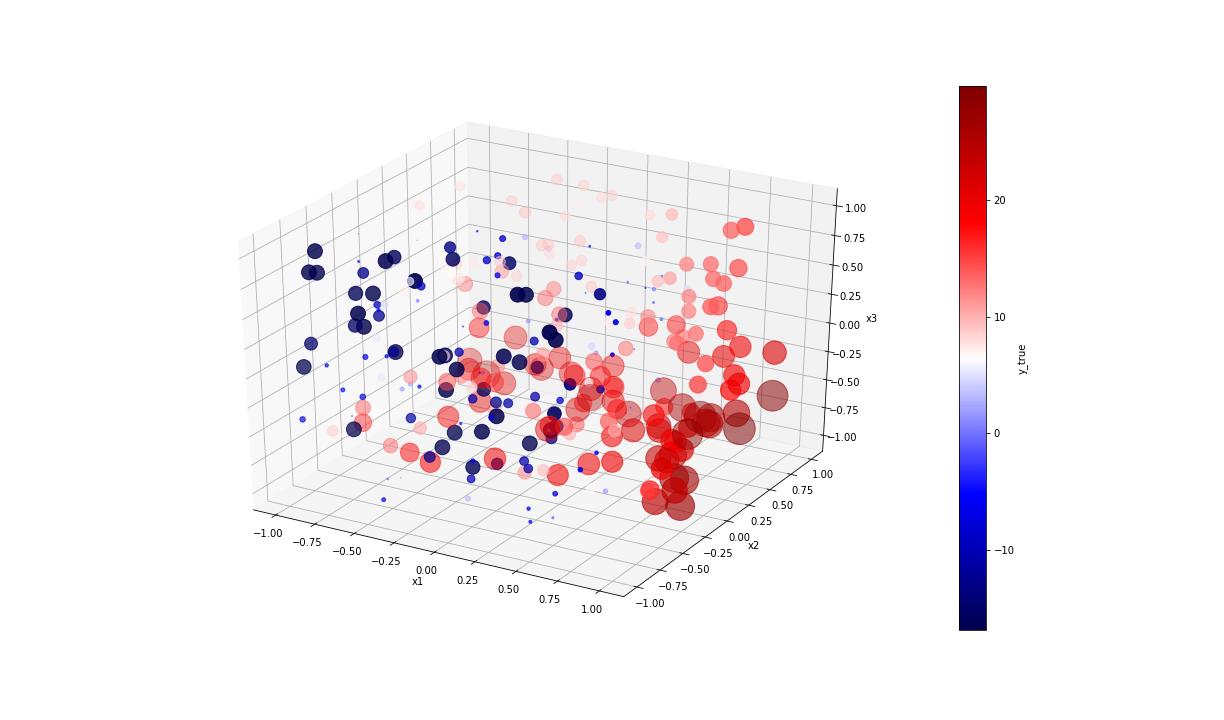

max : 29.725406646728516  min : -16.84182357788086


In [53]:
plot_4d(x[:,0], x[:,1], x[:,2], y2_pred)